<a href="https://colab.research.google.com/github/DyanielCX/DLI-Assm/blob/main/HoFengSheng_SVM_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Import Dependencies

In [1]:
import time
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from matplotlib import colormaps

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    confusion_matrix, classification_report, roc_auc_score,
    accuracy_score, precision_score, recall_score, f1_score,
    roc_curve, precision_recall_curve, average_precision_score
)
from sklearn.svm import LinearSVC

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Conv1D, GlobalMaxPooling1D, Dropout, Dense
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# 2. Load and Preprocess Dataset

In [2]:
github_csv_url = 'https://raw.githubusercontent.com/DyanielCX/DLI-Assm/refs/heads/main/dataset_B_05_2020_1.csv'
df = pd.read_csv(github_csv_url)
df['url'] = df['url'].str.lower()
y = df['status'].values

ml_features = df.drop(columns=['url', 'status'])
urls = df['url'].values

# Tokenize URLs (char level)
tokenizer = Tokenizer(char_level=True)
tokenizer.fit_on_texts(urls)
url_seqs = tokenizer.texts_to_sequences(urls)
X_url = pad_sequences(url_seqs, maxlen=200)
vocab_size = len(tokenizer.word_index) + 1

# 3. 🧠 Train CNN to Learn from URL

In [3]:
train_start_time = time.time()

# CNN architecture
input_layer = Input(shape=(200,))
embedding = Embedding(input_dim=vocab_size, output_dim=128)(input_layer)
conv = Conv1D(filters=256, kernel_size=5, activation='relu')(embedding)
drop = Dropout(0.3)(conv)
pool = GlobalMaxPooling1D(name="cnn_features")(drop)
output_layer = Dense(1, activation='sigmoid')(pool)

# Compile model
CNN_model = Model(inputs=input_layer, outputs=output_layer)
CNN_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Split for DL training only
X_train_dl, X_test_dl, y_train_dl, y_test_dl = train_test_split(X_url, y, test_size=0.2, stratify=y, random_state=42)

# Train CNN model
CNN_model.fit(X_train_dl, y_train_dl, epochs=5, batch_size=128, validation_split=0.1, verbose=1)
loss, acc = CNN_model.evaluate(X_test_dl, y_test_dl)
print(f"✅ CNN Accuracy: {round(acc * 100, 2)}%")


Epoch 1/5
65/65 ━━━━━━━━━━━━━━━━━━━━ 45s 638ms/step - accuracy: 0.7182 - loss: 0.5666 - val_accuracy: 0.8306 - val_loss: 0.3908
Epoch 2/5
65/65 ━━━━━━━━━━━━━━━━━━━━ 41s 632ms/step - accuracy: 0.8463 - loss: 0.3541 - val_accuracy: 0.8809 - val_loss: 0.3084
Epoch 3/5
65/65 ━━━━━━━━━━━━━━━━━━━━ 81s 613ms/step - accuracy: 0.8897 - loss: 0.2748 - val_accuracy: 0.9027 - val_loss: 0.2639
Epoch 4/5
65/65 ━━━━━━━━━━━━━━━━━━━━ 41s 619ms/step - accuracy: 0.9115 - loss: 0.2243 - val_accuracy: 0.9115 - val_loss: 0.2382
Epoch 5/5
65/65 ━━━━━━━━━━━━━━━━━━━━ 41s 623ms/step - accuracy: 0.9266 - loss: 0.1957 - val_accuracy: 0.9202 - val_loss: 0.2314
72/72 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - accuracy: 0.9246 - loss: 0.2174
✅ CNN Accuracy: 91.86%


 # 4. 📤 Extract CNN Features & Merge with ML Features

In [4]:
# Create a feature extractor model that outputs from 'cnn_features' layer
feature_extractor = Model(inputs=CNN_model.input,
                          outputs=CNN_model.get_layer("cnn_features").output)

# Apply on all padded URL sequences to extract CNN features
cnn_features = feature_extractor.predict(X_url)

# Standardize ML numerical features
scaler = StandardScaler()
ml_scaled = scaler.fit_transform(ml_features)

# Combine CNN features with numeric ML features
X_combined = np.hstack([cnn_features, ml_scaled])


358/358 ━━━━━━━━━━━━━━━━━━━━ 15s 41ms/step


# 5. 🤖 Train Final SVM Classifier

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.2, stratify=y, random_state=42)

svm_model = LinearSVC(
    loss="squared_hinge", penalty='l2', dual=True, max_iter=100000,
    tol=1e-3, class_weight='balanced', C=1.0, random_state=42
)

svm_model.fit(X_train, y_train)

LinearSVC(class_weight='balanced', dual=True, max_iter=100000, random_state=42,
          tol=0.001)

# 6. 📊 Evaluate Model


📋 Classification Report:

              precision    recall  f1-score   support

           0       0.96      0.96      0.96      1143
           1       0.96      0.96      0.96      1143

    accuracy                           0.96      2286
   macro avg       0.96      0.96      0.96      2286
weighted avg       0.96      0.96      0.96      2286


📊 Model Evaluation Summary
Accuracy            : 95.63%
Precision           : 95.55%
Recall              : 95.71%
F1-Score            : 95.63%
ROC AUC             : 99.16%
Training Time       : 5.00 minutes
Prediction Time     : 2.5535 ms



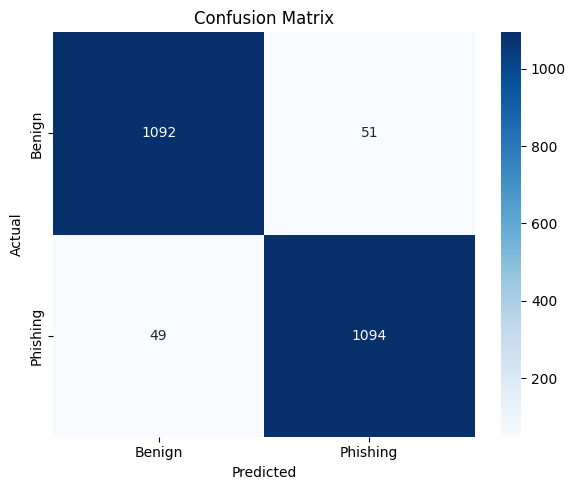

In [6]:
predict_start_time = time.time()
y_pred = svm_model.predict(X_test)
predict_time = time.time() - predict_start_time
train_time = time.time() - train_start_time

y_scores = svm_model.decision_function(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_scores)


print("\n📋 Classification Report:\n")
print(classification_report(y_test, y_pred))
print("\n📊 Model Evaluation Summary")
print("=" * 40)
print(f"{'Accuracy':<20}: {accuracy * 100:.2f}%")
print(f"{'Precision':<20}: {precision * 100:.2f}%")
print(f"{'Recall':<20}: {recall * 100:.2f}%")
print(f"{'F1-Score':<20}: {f1 * 100:.2f}%")
print(f"{'ROC AUC':<20}: {roc_auc * 100:.2f}%")
print(f"{'Training Time':<20}: {train_time / 60:.2f} minutes")
print(f"{'Prediction Time':<20}: {predict_time * 1000:.4f} ms")
print("=" * 40 + "\n")


# 🔷 Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Benign", "Phishing"],
            yticklabels=["Benign", "Phishing"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()


## 6.1 📈 ROC & PR Curve

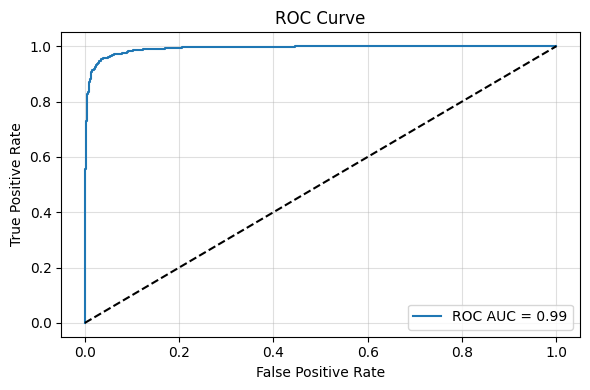

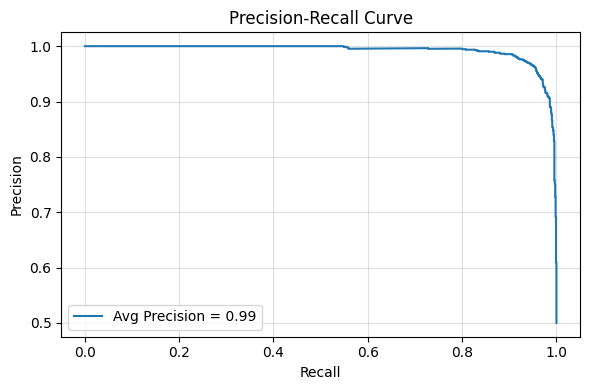

In [7]:
# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_scores)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f'ROC AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.grid(alpha=0.4)
plt.legend()
plt.tight_layout()
plt.show()

# PR Curve
prec_vals, rec_vals, _ = precision_recall_curve(y_test, y_scores)
avg_prec = average_precision_score(y_test, y_scores)
plt.figure(figsize=(6, 4))
plt.plot(rec_vals, prec_vals, label=f'Avg Precision = {avg_prec:.2f}')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.grid(alpha=0.4)
plt.legend()
plt.tight_layout()
plt.show()

# 7. 📈 Compare with Researcher Model

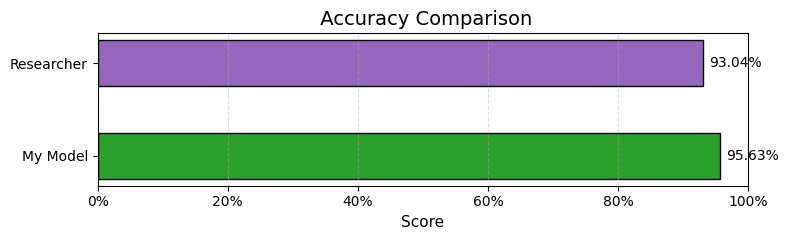

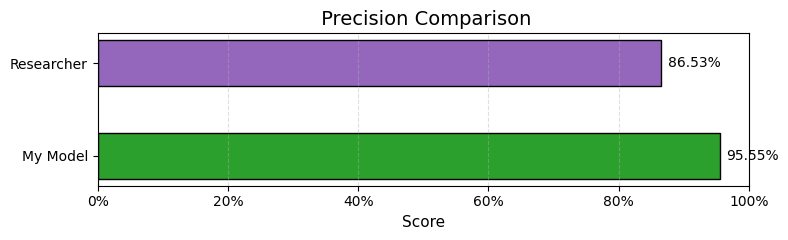

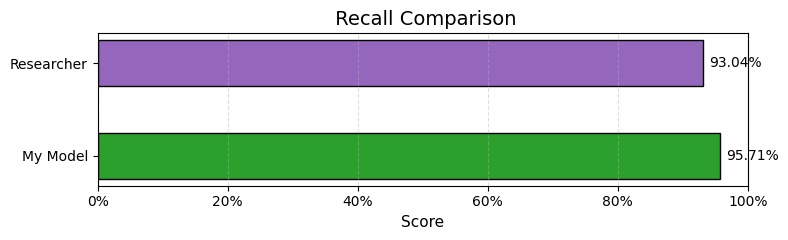

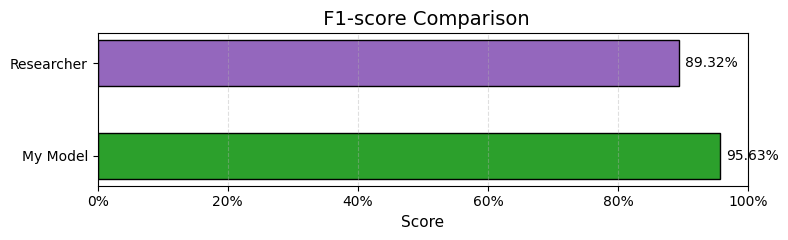

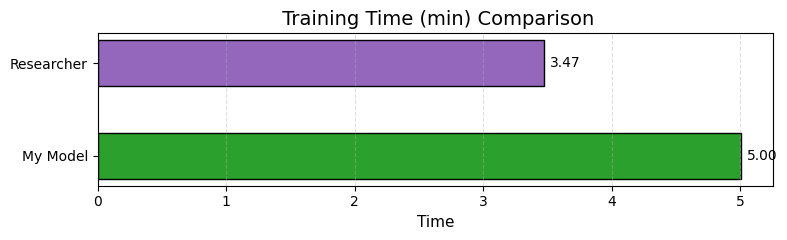

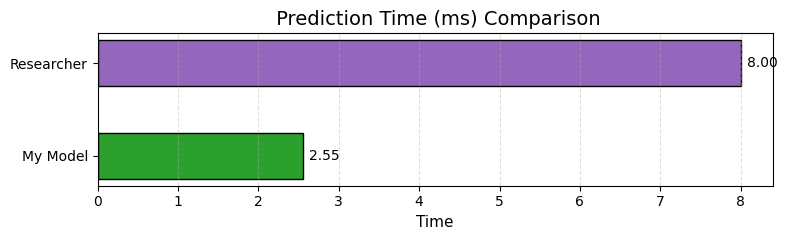

In [8]:
researcher_metrics = {
    'Accuracy': 93.04,
    'Precision': 86.53,
    'Recall': 93.04,
    'F1-score': 89.32,
    'Training Time (min)': 3.47,
    'Prediction Time (ms)': 8
}

my_metrics = {
    'Accuracy': accuracy * 100,
    'Precision': precision * 100,
    'Recall': recall * 100,
    'F1-score': f1 * 100,
    'Training Time (min)': train_time / 60,
    'Prediction Time (ms)': predict_time * 1000
}

labels = ['My Model', 'Researcher']
percent_metrics = ['Accuracy', 'Precision', 'Recall', 'F1-score']
cmap = colormaps.get_cmap("tab10")

for metric in my_metrics:
    fig, ax = plt.subplots(figsize=(8, 2.5))
    values = [my_metrics[metric], researcher_metrics[metric]]
    bars = ax.barh(labels, values, height=0.5,
                   color=[cmap(0.2), cmap(0.4)],
                   edgecolor='black')
    ax.set_title(f" {metric} Comparison", fontsize=14)
    ax.set_xlabel("Score" if metric in percent_metrics else "Time", fontsize=11)
    ax.xaxis.grid(True, linestyle='--', alpha=0.4)

    if metric in percent_metrics:
        ax.set_xlim(0, 100)
        ax.xaxis.set_major_formatter(mtick.PercentFormatter())

    for bar in bars:
        width = bar.get_width()
        label = f"{width:.2f}%" if metric in percent_metrics else f"{width:.2f}"
        ax.text(width + max(values) * 0.01,
                bar.get_y() + bar.get_height() / 2,
                label, ha='left', va='center', fontsize=10)

    plt.tight_layout()
    plt.show()
